## Density Field Analysis of Environment around DLAs
This code computes the overdensity in the environment of a DLA-host Halo by shooting lines of sight along the Halos of interest and plotting the overdensity along it.<br>
The density field file is a CIC approximation as given by Aseem. CIC is of the same snapshot from which the Mock Halo catalogue for 2PC was extracted.<br>
The simulation box is treated to be Periodic.<br>
The algorithm followed by this code is -<br>
<ul>
    <li>Choose set of random halos from each of the 3 catalogues given.</li>
    <li>Choose random non-zero parameters P=(Ai,Bi,Ci) for the current run. With the position of the center of the halo H=(X0,Y0,Z0), create an array of tuples (Xi,Yi,Zi) which are points sampled along the 3D line traced by P and H. The length predefined is 150MPc, centered at the center of the Halo (H).</li>
    <li>Find the overdensity values interpolated at these new set of points and plot them as overdensity along the line of sight. Important to take into account Periodic Boundary considerations.</li>
</ul>
Encoded in Analyse mode <i>"general"</i><br>
<br>
<i>Update: 14th May, 2019 <br></i>
One alternative to the above method is to draw a line of sight parallel to either of the x,y,z axes, with points lying on the grid corners so that interpolation of CIC is not required.<br>

Encoded in Analyse mode <i>"simple"</i><br>

<i>Update: 16th May, 2019</i><br>
Aim of this analysis is to move towards a more statistically robust estimate of clustering around the environment of the Halos of interest. The updated exercise is as follows-
<ul>
    <li>Shoot lines of sight parallel to one of the axes for all the halos in the given catalogues.</li>
    <li>Find the Overdensity amplitude values at all the points on these lines with the Halo of interest at the center.</li>
    <li>Find the mean at each scale and produce a plot with mean values and standard deviation for each "r" for each catalogue.</li>
    <li>Can be extended to be more robust by shooting L.O.S. from all 3 directions to triple the DF values.</li>
</ul>

Note: The direction wouldn't matter in such averaging from the isotropic assumption for our Universe, hence, no need to worry about the Line inclined correctly. On an average it should give a good representation of the real situation.<br>
<br>
Encoded in Analyse mode <i>"averaged"</i>

Quoting the medians with 75th and 25th percentiles is achieved from the code in analysis mode <i>"averagedLOSv2"</i>

<i>Update: 25th May, 2019</i>
Halo environments will not vary at such high scales of 150MPc. They will vary in the nearby surroundings. Aseem suggests to change the scaling from MPc to <i>r/r200b</i> , where r200b is the radius at which the Halo density is 200 times the background density, and plot the DF analysis curves at an upper limit of r/r200b of about 10.

The r_200b for each Halo of interest is available in the master catalogue of halos given by Aseem from his simulations. This source file will not be avaiable on GitHub because of its large size (~1GB)

In [2]:
# This cell: Libraries imported and general data to be used is loaded
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

colors=['g','b','r']
sourcePath="../SourceData/"  # Will not become a member of the git commits because CIC file is 1.1GB
fileNames=['b1','b1alpha','b1T10']
# Loading CIC data of density field. (512^3)
GridSize=512  # cubed of course.
cicSource="cic_snap049_grid512.dat"
data1=np.fromfile(sourcePath+cicSource)
data=np.reshape(data1,(GridSize,GridSize,GridSize))

In [3]:
# This cell: Cosmology is defined. Simulation details are listed. Other constants to be used throughout are specified.
# Aseem's Cosmology
sigma_8=0.811
ns=0.961
h=0.7
Ob=0.045
Om=0.276

z=2.3         # Redshift specification
M_sun=1.989e+30  # M_sun in kg
Mega_parsec=3.086e+22  # parsec in metres
Delta=200.0   # Overdensity definition = Delta X background
rho_cr=((3*(100*h)**2)/(8*np.pi*6.673e-11))*((Mega_parsec/h**3)*1e+6/(M_sun/h))
# critical density of the Universe today 3H^2/8Pi*G in units M_sun.h^-1/(MPc.h^-1)^3
rho_m=Om*rho_cr # Units same as rho_cr. Don't need redshift considerations in comoving units i.e. Msun/h and MPc/h
del_crit=1.69
Lbox=150.0   # MPc/h

In [4]:
# This cell: Utility function to randomly choose 1 halo from each of the 3 catalogues currently being studied
def pickHalo():
    pickedHalos=[]    # to store randomly picked halos
    for name in fileNames:
        mocks=pickle.load(open(sourcePath+name+'.pickled','rb'))
        r=int(np.floor(float(np.random.rand(1))*mocks[:,0].size))
        pickedHalos.append(mocks[r])
    return(np.array(pickedHalos))

In [5]:
# This cell: General Lines of Sights may not pass through CIC grid points always.
# The following code interpolates values from the surrounding grid points as defined by the CIC code.
# Caution: This is an interpolation of an interpolation. Expect bad approximations of the values.
def revCIC(p):
    
    result=0.0
    p_grid=p
    p_grid[p_grid>=Lbox]=p_grid[p_grid>=Lbox]-Lbox  # Periodicity considerations
    #p_grid[p_grid<0.0]=p_grid[p_grid<0.0]+Lbox    # Periodicity considerations
    p_grid=(GridSize-1)*p_grid/Lbox                   # Halo co-ods to grid co-ods
    x,y,z=p_grid[0],p_grid[1],p_grid[2]
    
    p_=np.floor(p_grid)
    x_,y_,z_=int(p_[0]),int(p_[1]),int(p_[2])
    
    result+=data[x_,y_,z_]*(x_+1-x)*(y_+1-y)*(z_+1-z)
    result+=data[x_+1,y_,z_]*(x-x_)*(y_+1-y)*(z_+1-z)
    result+=data[x_,y_+1,z_]*(x_+1-x)*(y-y_)*(z_+1-z)
    result+=data[x_,y_,z_+1]*(x_+1-x)*(y_+1-y)*(z-z_)
    result+=data[x_+1,y_+1,z_]*(x-x_)*(y-y_)*(z_+1-z)
    result+=data[x_+1,y_,z_+1]*(x-x_)*(y_+1-y)*(z-z_)
    result+=data[x_,y_+1,z_+1]*(x_+1-x)*(y-y_)*(z-z_)
    result+=data[x_+1,y_+1,z_+1]*(x-x_)*(y-y_)*(z-z_)
    
    return result

In [6]:
#LOS Method implemented does an interpolation of the CIC in a randomly picked 3D line

sign=lambda x,y: -1 if x<y else 1

def generalLOS(halo):
    pos,df=[],[]
    grain=250
    
    params=np.random.rand(3)*10
    t=Lbox*0.5/(np.sqrt(np.sum(np.power(params,2))))

    X=np.linspace(halo[0]-params[0]*t,halo[0]+params[0]*t,grain)
    Y=np.linspace(halo[1]-params[1]*t,halo[1]+params[1]*t,grain)
    Z=np.linspace(halo[2]-params[2]*t,halo[2]+params[2]*t,grain)

    for i in range(0,grain):
        p=np.array([X[i],Y[i],Z[i]])
        pos.append(sign(p[0],halo[0])*np.sqrt(np.sum((p-halo)**2)))
        df.append(revCIC(p))
        
    return np.array(pos),np.array(df)

In [7]:
# The LOS Method implemented has lines always passing parallel to x-axis and through the grid points
# Direction specifies which direction the LOS should be parallel to
# Returns the value of density contrast at each position for the Line of Sight (LOS) shot.
# Note: position will always be distance from the center of the Halo

def simpleLOS(halo,direction='x'):
    pos,df=[],[]
    
    X=int(np.floor(halo[0]*(GridSize-1)/Lbox))
    Y=int(np.floor(halo[1]*(GridSize-1)/Lbox))
    Z=int(np.floor(halo[2]*(GridSize-1)/Lbox))
    dl=Lbox/GridSize   # MPc/CICcell
    offset=int(-GridSize/2)

    for i in range(0,GridSize):
        pos.append((i+offset)*dl)
        p=[]
        if direction=='x':
            p=np.array([X+i+offset,Y,Z])   
        elif direction=='y':
            p=np.array([X,Y+i+offset,Z])  
        elif direction=='z':
            p=np.array([X,Y,Z+i+offset])   
        else:
            print("Please choose a valid direction for the LOS. Valid choices are - x | y | z")
            exit()
            
        p[p>=GridSize]=p[p>=GridSize]-GridSize
        p[p<0]=p[p<0]+GridSize   # periodicty of the box considered
        df.append(data[p[0],p[1],p[2]])  
        
    return np.array(pos),np.array(df)

In [8]:
# The LOS Method implemented has lines always passing parallel to x-axis and through the grid points
# Direction specifies which direction the LOS are parallel to
# r_lim specifies the limit to which LOS calculations should be done about the central position of the halo
# Limit should be specified in the form of a fractional number f<1.0, such that calculations will be done upto r=Lbox*f

def simpleLimLOS(halo,direction='x',rlim=0.1):
    pos,df=[],[]
    
    grid2box=Lbox/GridSize   # MPc/CICcell
    box2grid=(GridSize-1)/Lbox   # CICcells/MPc
    
    X=int(np.floor(halo[0]*box2grid))
    Y=int(np.floor(halo[1]*box2grid))
    Z=int(np.floor(halo[2]*box2grid))
    
    scaleCap=int(np.floor(Lbox*rlim*box2grid))
    offset=int(scaleCap/-2)

    for i in range(0,scaleCap):
        pos.append((i+offset)*grid2box)
        p=[]
        if direction=='x':
            p=np.array([X+i+offset,Y,Z])   
        elif direction=='y':
            p=np.array([X,Y+i+offset,Z])  
        elif direction=='z':
            p=np.array([X,Y,Z+i+offset])   
        else:
            print("Please choose a valid direction for the LOS. Valid choices are - x | y | z")
            exit()
            
        p[p>=GridSize]=p[p>=GridSize]-GridSize
        p[p<0]=p[p<0]+GridSize   # periodicty of the box considered
        df.append(data[p[0],p[1],p[2]])  
        
    return np.array(pos),np.array(df)

In [9]:
# Helping functions for asymmetric STD calculations in averagedLOS()
# Asymmetry in statistics. Data is split into values above and below mean. A different standard deviation is found for each set.

# This function finds the STD given the mean value
def std_dev(a,mean):
    return np.sqrt(np.sum((a-mean)**2)/a.size)

# This function returns the positive and negative STD given the total dataset and axis about which to compute
def asymmetricSTD(a,ax):
    means=np.mean(a,axis=ax)
    SDPos,SDNeg=[],[]
    for i in range(0,len(means)):
        pos,neg=[],[]
        currMean=means[i]
        for j in range(0,a.shape[ax]):
            tmp=a[j,i]   # axis specific. Assumed that j in indexed first. Need to update for generalization
            if tmp>=currMean:
                pos.append(tmp)
            else:
                neg.append(tmp)
        SDPos.append(std_dev(np.array(pos),currMean))
        SDNeg.append(std_dev(np.array(neg),currMean))

    return np.array(SDPos),np.array(SDNeg)

In [10]:
# LOS method implemented has lines passing through every halo of each catalogue to give a statistically robust estimate
# Arguments specifies the current file in considerations and...
# ...how many direction to consider for calculating the LOS - all | x | y | z

def averagedLOS(fileIndex,direction='all'):
    
    options=np.array(['all','x','y','z'])
    if not any(options == direction):
        print("Please enter a valid value to direction argument. Valid values -- all | x | y | z")
        print("Jupyter Notebook kernel will be killed")
        exit()
    
    mocks=pickle.load(open(sourcePath+fileNames[fileIndex]+'.pickled','rb'))
    masterPos,dummy=simpleLOS(mocks[0])
    masterDF,resultDF,resultSDPos,resultSDNeg=[],[],[],[]
    # masterDF will store LOS DF for each halo in mocks
    # resultDF will be the mean of masterDF at each scale
    # resultPosSD will hold the standard deviation of LOS DF values only above(or equal to) the mean
    # resultNegSD is same as above for LOS DF values below the mean
    
    if direction == 'all':
        for halo in mocks:
            for axis in ['x','y','z']:
                pos,df=simpleLOS(halo,axis)
                masterDF.append(df)
        masterDF=np.array(masterDF)
        resultDF=np.mean(masterDF,axis=0)
        resultSDPos,resultSDNeg=asymmetricSTD(masterDF,ax=0)
      
    else:
        for halo in mocks:
            pos,df=simpleLOS(halo,direction)
            masterDF.append(df)
        masterDF=np.array(masterDF)
        resultDF=np.mean(masterDF,axis=0)
        resultSDPos,resultSDNeg=asymmetricSTD(masterDF,ax=0)
        
    return masterPos,resultDF,resultSDPos,resultSDNeg

In [16]:
start=time.time()
p_b1,df_b1,sdp_b1,sdn_b1=averagedLOS(0,'all')
p_alpha,df_alpha,sdp_alpha,sdn_alpha=averagedLOS(1,'all')
p_t10,df_t10,sdp_t10,sdn_t10=averagedLOS(2,'all')
end=time.time()
print("Computed averagedLOS in "+str(end-start)+" seconds")

Computed averagedLOS in 717.2245054244995 seconds


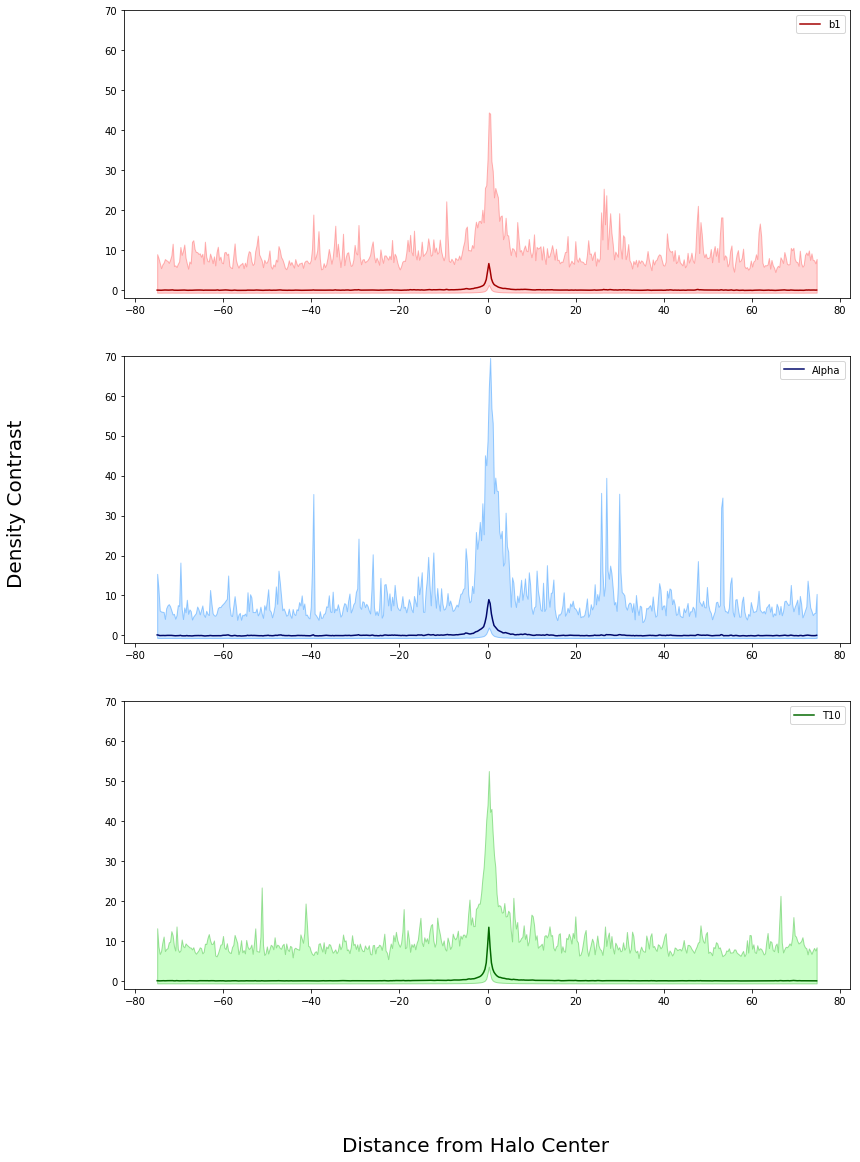

In [17]:
# This cell is specifically made to run the averagedLOS() function because of more complex plotting details.

fig,ax=plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(13,18))
fig.text(0.5, 0.0, 'Distance from Halo Center', ha='center',fontsize=20)
fig.text(0.0, 0.5, 'Density Contrast', va='center', rotation='vertical',fontsize=20)

plt.subplot(3,1,1)
plt.plot(p_b1, df_b1, 'k', color='#A30000',label="b1")
plt.fill_between(p_b1, df_b1-sdn_b1, df_b1+sdp_b1,alpha=0.5, edgecolor='#FF6B6B', facecolor='#FFADAD')
plt.ylim([-2,70])
plt.legend()

plt.subplot(3,1,2)
plt.plot(p_alpha, df_alpha, 'k', color='#00086B',label="Alpha")
plt.fill_between(p_alpha, df_alpha-sdn_alpha, df_alpha+sdp_alpha,alpha=0.5, edgecolor='#3a9cff', facecolor='#9bcdff')
plt.ylim([-2,70])
plt.legend()

plt.subplot(3,1,3)
plt.plot(p_t10, df_t10, 'k', color='#036800',label="T10")
plt.fill_between(p_t10, df_t10-sdn_t10, df_t10+sdp_t10,alpha=0.5, edgecolor='#49c145', facecolor='#96ff93')
plt.ylim([-2,70])
plt.legend()

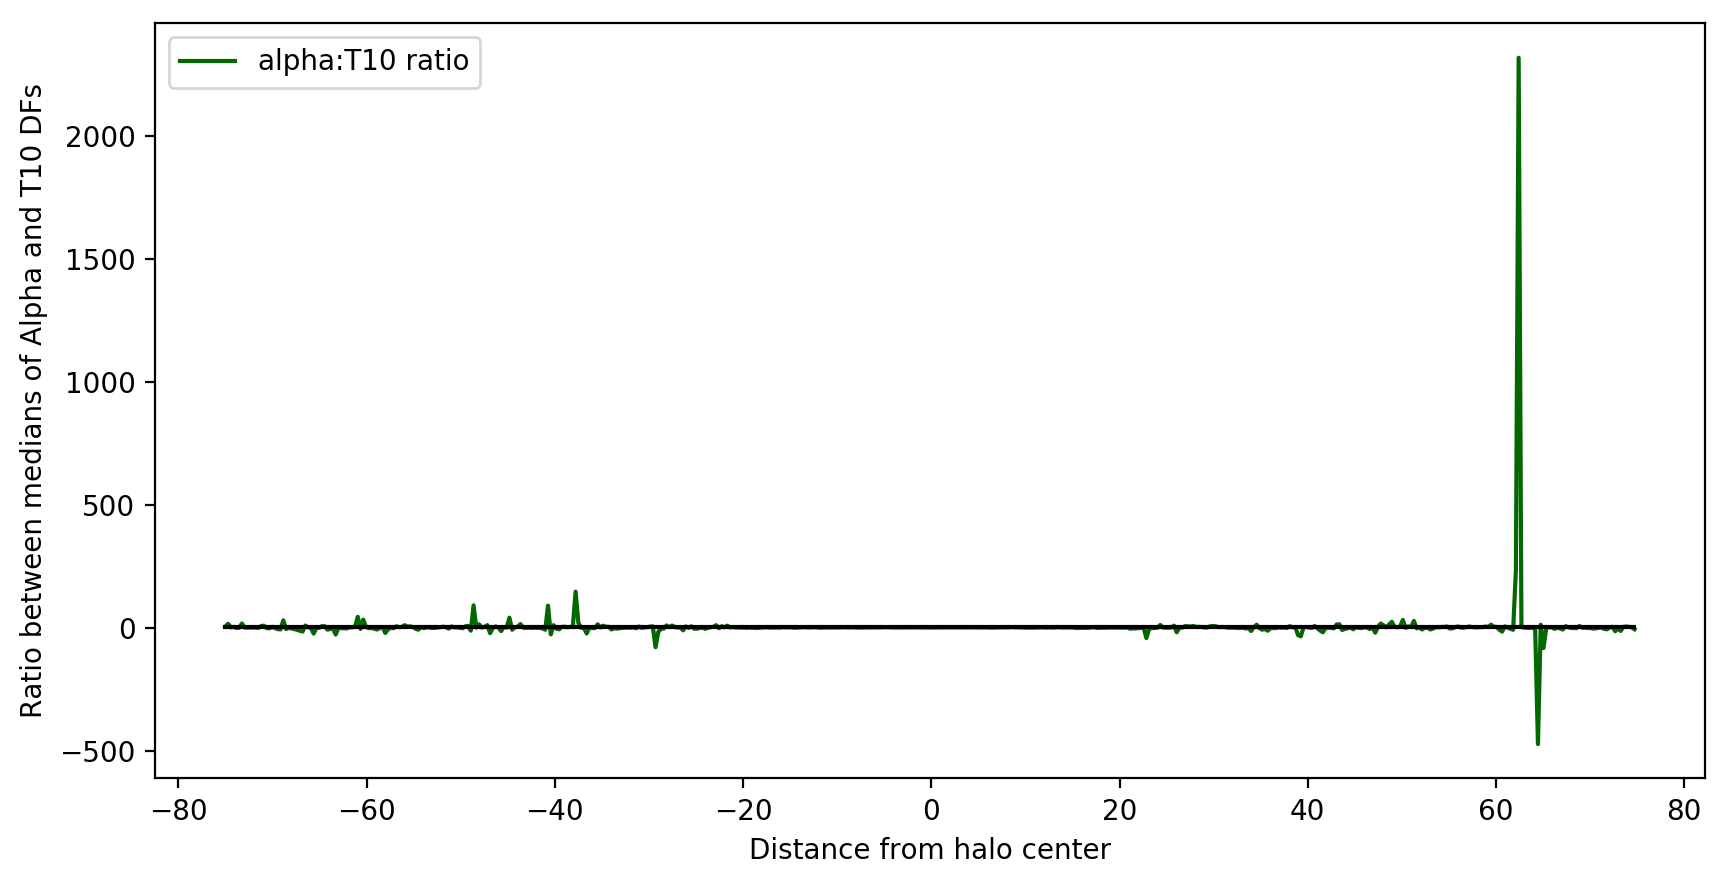

In [18]:
plt.figure(2,figsize=(10,5),dpi=200)
plt.plot(p_alpha,df_alpha/df_t10,color='#036800',label="alpha:T10 ratio")
plt.plot(p_alpha,np.ones(p_alpha.size),'k')
plt.xlabel("Distance from halo center")
plt.ylabel("Ratio between medians of Alpha and T10 DFs")
plt.legend()
plt.show()

In [11]:
# LOS method implemented has lines passing through every halo of each catalogue to give a statistically robust estimate
# Arguments specifies the current file in considerations and...
# ...how many direction to consider for calculating the LOS - all | x | y | z
# This function differs from above in the statistics quoted at the end. 
# Median, 16th Percentile and 84th Percentile is plotted in this.

def averagedLOSv2(fileIndex,direction='all'):
    f=0.3   # calculations will be done to a scale f*Lbox around the center of halo
    options=np.array(['all','x','y','z'])
    if not any(options == direction):
        print("Please enter a valid value to direction argument. Valid values -- all | x | y | z")
        print("Jupyter Notebook kernel will be killed")
        exit()
    
    mocks=pickle.load(open(sourcePath+fileNames[fileIndex]+'.pickled','rb'))
    masterPos,dummy=simpleLimLOS(mocks[0],rlim=f)
    masterDF,resultDF,prcntile16,prcntile84=[],[],[],[]
    # masterDF will store LOS DF for each halo in mocks
    # resultDF will be the mean of masterDF at each scale
    # resultPosSD will hold the standard deviation of LOS DF values only above(or equal to) the mean
    # resultNegSD is same as above for LOS DF values below the mean
    
    if direction == 'all':
        for halo in mocks:
            for axis in ['x','y','z']:
                #pos,df=simpleLOS(halo,axis)
                pos,df=simpleLimLOS(halo,axis,rlim=f)
                masterDF.append(df+1.0)
        masterDF=np.array(masterDF)
        resultDF=np.median(masterDF,axis=0)
        prcntile16=np.percentile(masterDF,16,axis=0)
        prcntile84=np.percentile(masterDF,84,axis=0)
      
    else:
        for halo in mocks:
            #pos,df=simpleLOS(halo,direction)
            pos,df=simpleLimLOS(halo,axis,rlim=f)
            masterDF.append(df+1.0)
        masterDF=np.array(masterDF)
        resultDF=np.median(masterDF,axis=0)
        prcntile16=np.percentile(masterDF,16,axis=0)
        prcntile84=np.percentile(masterDF,84,axis=0)
        
    return masterPos,resultDF,prcntile16,prcntile84

In [24]:
start=time.time()
p_b1v2,df_b1v2,pt16_b1v2,pt84_b1v2=averagedLOSv2(0,'all')
p_alphav2,df_alphav2,pt16_alphav2,pt84_alphav2=averagedLOSv2(1,'all')
p_t10v2,df_t10v2,pt16_t10v2,pt84_t10v2=averagedLOSv2(2,'all')
end=time.time()
print("Computed averagedLOSv2 in "+str(end-start)+" seconds")

Computed averagedLOSv2 in 188.238028049469 seconds


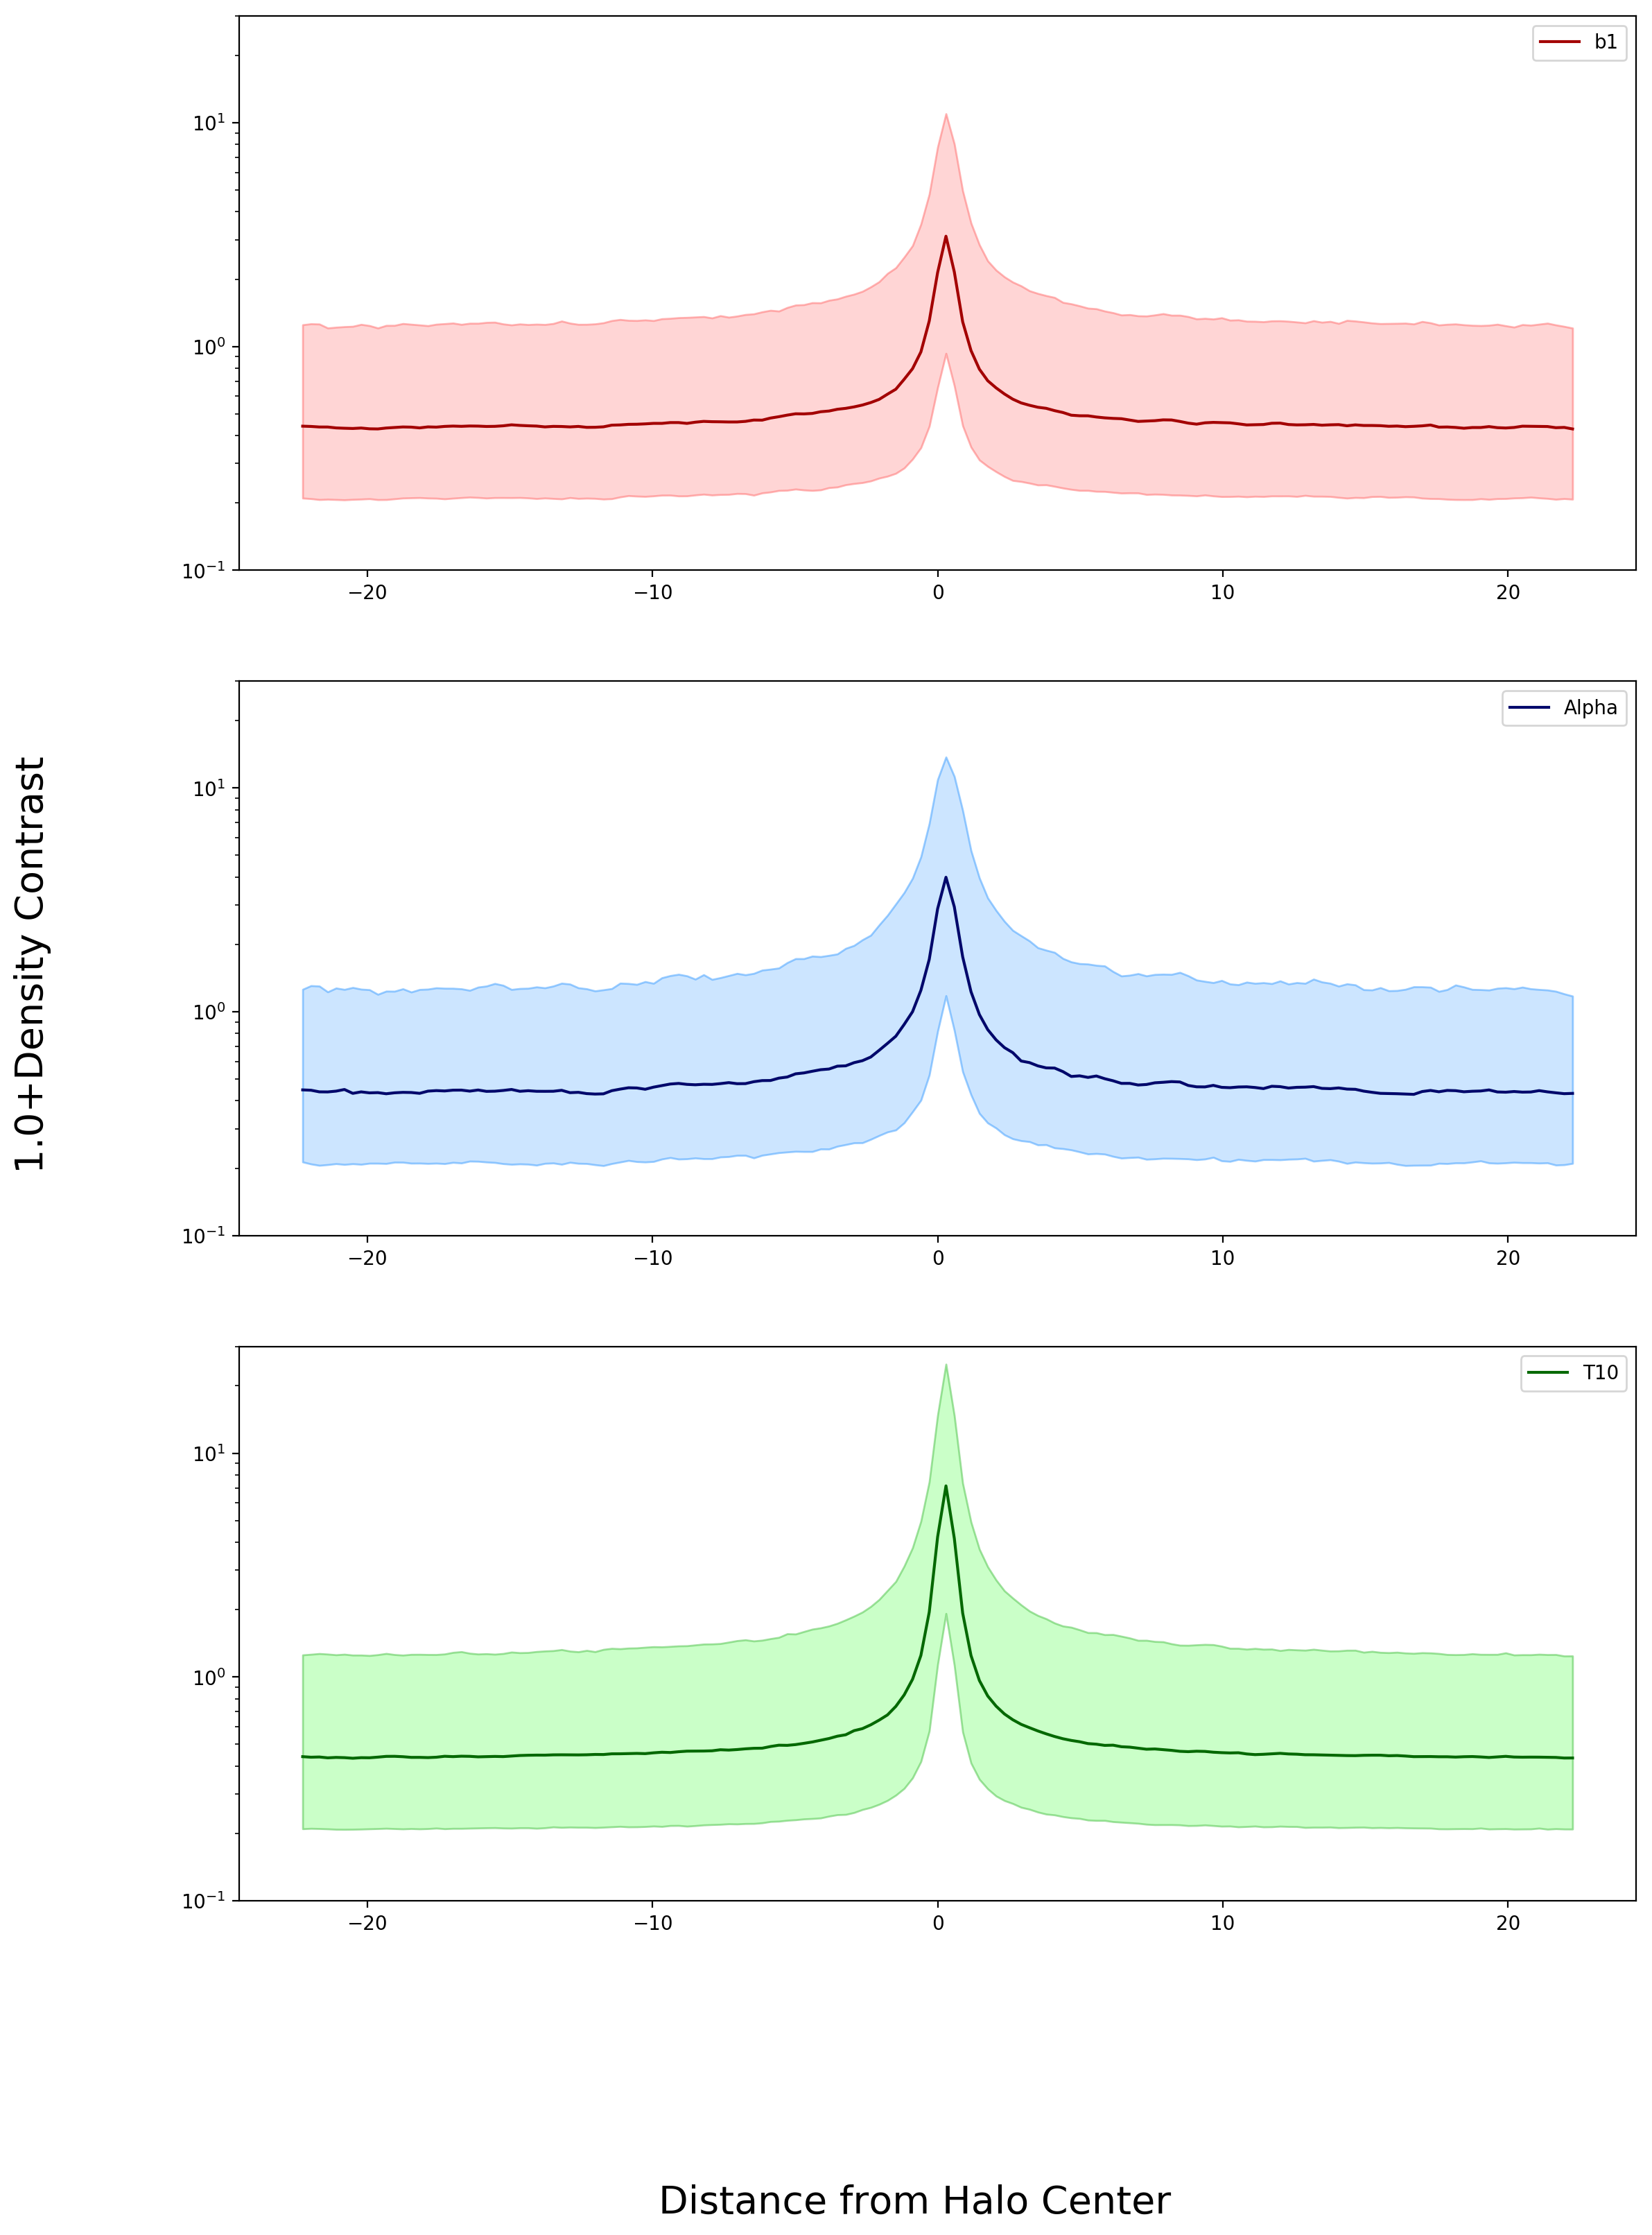

In [25]:
# This cell is specifically made to run the averagedLOSv2() function because of more complex plotting details.

fig,ax=plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(13,18),dpi=200)
fig.text(0.5, 0.0, 'Distance from Halo Center', ha='center',fontsize=20)
fig.text(0.0, 0.5, '1.0+Density Contrast', va='center', rotation='vertical',fontsize=20)

plt.subplot(3,1,1)
plt.plot(p_b1v2, df_b1v2, 'k', color='#A30000',label="b1")
plt.fill_between(p_b1v2, pt84_b1v2, pt16_b1v2,alpha=0.5, edgecolor='#FF6B6B', facecolor='#FFADAD')
plt.ylim([0.1,3e1])
plt.yscale('log')
plt.legend()

plt.subplot(3,1,2)
plt.plot(p_alphav2, df_alphav2, 'k', color='#00086B',label="Alpha")
plt.fill_between(p_alphav2, pt84_alphav2, pt16_alphav2,alpha=0.5, edgecolor='#3a9cff', facecolor='#9bcdff')
plt.ylim([0.1,3e1])
plt.yscale('log')
plt.legend()

plt.subplot(3,1,3)
plt.plot(p_t10v2, df_t10v2, 'k', color='#036800',label="T10")
plt.fill_between(p_t10v2, pt84_t10v2, pt16_t10v2,alpha=0.5, edgecolor='#49c145', facecolor='#96ff93')
plt.ylim([0.1,3e1])
plt.yscale('log')
plt.legend()

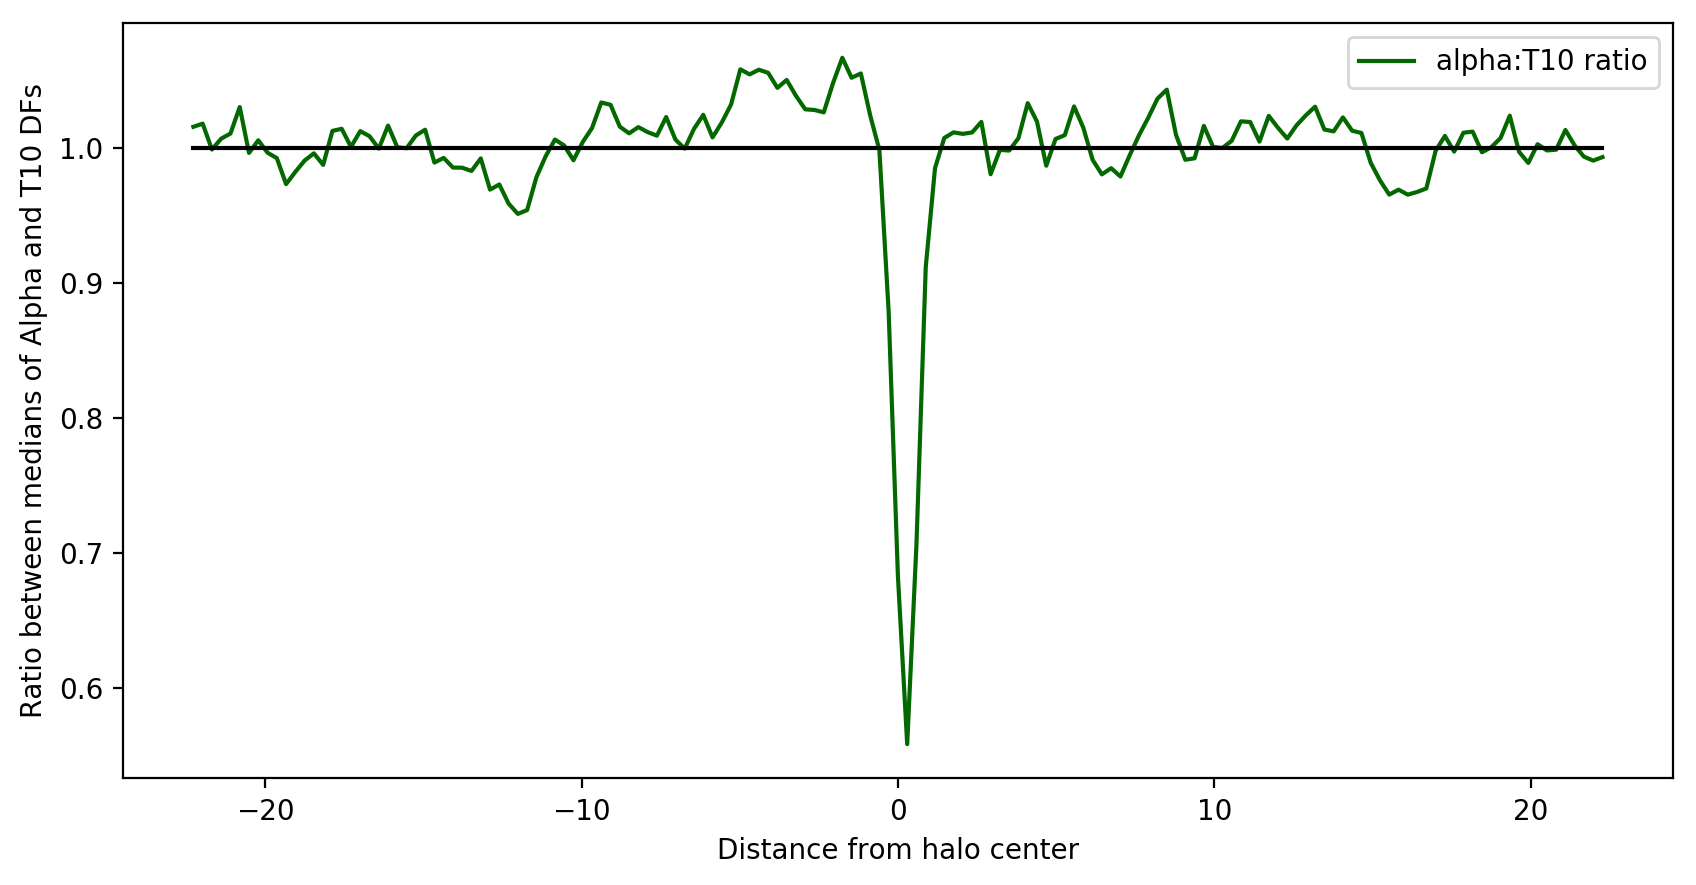

In [26]:
plt.figure(2,figsize=(10,5),dpi=200)
plt.plot(p_alphav2,df_alphav2/df_t10v2,color='#036800',label="alpha:T10 ratio")
plt.plot(p_alphav2,np.ones(p_alphav2.size),'k')
plt.xlabel("Distance from halo center")
plt.ylabel("Ratio between medians of Alpha and T10 DFs")
plt.legend()
plt.show()

In [11]:
# find density in the environment of randomly picked halos
# type= simple | general | averaged

def Analyse(runs,type='averaged'):
    #plt.figure(0,figsize=(10,18),dpi=200, facecolor='w', edgecolor='k')
    #plt.title('Density field along L.O.S parallel to x-axis')
    Nrows=runs
    Ncols=len(fileNames)
    fig,ax=plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(16,28))
    fig.text(0.5, 0.0, 'Distance from Halo Center', ha='center',fontsize=20)
    fig.text(0.0, 0.5, 'Overdensity Amplitude', va='center', rotation='vertical',fontsize=20)
    
    for k in range(0,runs):
        haloList=pickHalo()
        grain=100
        for j in range(0,len(fileNames)):
            halo=haloList[j]
            pos,df=[],[]

            if(type=='general'):
                pos,df=generalLOS(halo)
            elif(type=='simple'):
                pos,df=simpleLOS(halo,direction='x')
            elif(type=='averaged'):
                #pos,df,varDF=averagedLOS(j,direction='all')
                pos,df=averagedLOS(j,direction='all')
            else:
                print("Please select a valid mode.\nAvailable modes are- simple | general | averaged")
                exit()

            plt.subplot(Nrows,Ncols,3*k+j+1)
            plt.plot(pos,df,color=colors[j],markersize=1)
            plt.ylim([-1,35])

    plt.show()

In [ ]:
N=10  # Number of Halos to comapre and plot
start=time.time()
Analyse(N,type='averaged')
end=time.time()
print("Computed DF in "+str(end-start)+" seconds")

## Implementing r200b scaling
The following cells build utilities and computations to develop on the idea presented in the latest update of 25th May in the introduction.<br>
r200b will be found from M200b and the background density.

## linDensityLOS(i,d)
The statistics developed above for LOS analysis have a redundancy due to direction. The density field on either side of a halo of interest should not be treated separately if we believe in the isotropy of the Universe. Hence, a still better estimate should be to analyse the density of the distribution around the halo of interest. This will become clear through the description of the following procedure-
<ol>
    <li>Lines of Sight are shot parallel to the grid through the centers of all the Halos of interest from a given mock catalogue and the overdensity amplitude is computed at every scale around the halo.</li>
    <li>A bracket of <i>L MPc</i> is introduced symmetrically around the Halo of interest. The average linear density of total amplitude enclosed in the bracket is found and plotted against scale. In the formula below <i>i</i> iterates over all grid points contained in the enclosing bracket imposed on the Halo environment.
        $$\lambda(L)=\dfrac{\sum_{i}A_i}{L}$$

</ol>

In [12]:
# Loading master catalogue data and putting it in usbale format
masterCat=np.loadtxt(sourcePath+"out_49.trees")

treesID=np.array(masterCat[:,1],dtype=int)  # ID of halos in the master catalogue
treesR200b=np.cbrt((masterCat[:,36]*3)/(4*np.pi*rho_m*200))   # The r200b of each halo from the master catalogue.
treesMap=np.column_stack((treesID,treesR200b))
treesMap=treesMap[treesMap[:,0].argsort()]   # TreesMap is a 2 column array with R200b for given ID of the halo
# TreesMap is sorted wrt the ID column so that Binary Search can be done on it too save shitloads of time.

In [13]:
# Loading the given Halo catalogues from original non-pickled files to get ID's and positions
b1=np.loadtxt(sourcePath+'b1.txt')
b1alpha=np.loadtxt(sourcePath+'b1alpha.txt')
b1T10=np.loadtxt(sourcePath+'b1T10.txt')

b1ID,b1alphaID,b1T10ID=np.array(b1[:,0],dtype=int),np.array(b1alpha[:,0],dtype=int),np.array(b1T10[:,0],dtype=int)
b1Pos,b1alphaPos,b1T10Pos=[],[],[]

b1Pos.append(b1[:,1])
b1Pos.append(b1[:,2])
b1Pos.append(b1[:,3])
b1Pos=np.array(b1Pos)
b1Pos=b1Pos.T  # Holds the positions of all the b1 halos in order according to b1T10

b1alphaPos.append(b1alpha[:,1])
b1alphaPos.append(b1alpha[:,2])
b1alphaPos.append(b1alpha[:,3])
b1alphaPos=np.array(b1alphaPos)
b1alphaPos=b1alphaPos.T

b1T10Pos.append(b1T10[:,1])
b1T10Pos.append(b1T10[:,2])
b1T10Pos.append(b1T10[:,3])
b1T10Pos=np.array(b1T10Pos)
b1T10Pos=b1T10Pos.T

In [14]:
# Returns an array of r200b for each ID passed as an argument, in order
# Note that treesMap is sorted on IDs and hence, we can run a Binary Search on it

def findR200b(ID):
    low,high=0,treesMap[:,0].size-1
    while(low<=high):
        mid=int(low+(high-low)/2)
        if(ID==treesMap[mid,0]):
            return(treesMap[mid,1])
        elif(ID>treesMap[mid,0]):
            low=mid+1
        else:
            high=mid-1
    return(-1)

In [15]:
# consistency check cell. Please ignore.
t10r,alphar,b1r=[],[],[]
for i in b1ID:
    b1r.append(findR200b(i))
for j in b1alphaID:
    alphar.append(findR200b(j))
for k in b1T10ID:
    t10r.append(findR200b(k))
    
b1r=np.array(b1r)
alphar=np.array(alphar)
t10r=np.array(t10r)

In [16]:
print(np.array([(np.mean(10*b1r)),np.mean(10*alphar),np.mean(10*t10r)]))

[1.00645603 0.89497071 1.81024704]


In [34]:
Lbox/GridSize

0.29296875

In [1]:
# The purpose of existence of this function is explained in function: averagedLOS_R200b() 2 cells later
# This function return column wise statistics of 2 types
# 1] mode='std' enables asymmetric standard deviation calculations about the mean value.
# returned values are-- the mean, the std of points above mean, std of points below mean.
# 2] mode='percentile' returns 3 values-- median, 16th percentile, 84th percentile

def customStats(pos,DF,mode):
    allModes=np.array(['std','percentile'])  # list of all available modes. Add to this list if developed further
    if not any(mode==allModes):
        print("Please enter a valid mode. Current available modes are - "+str(allModes))
        print("Jupyter Notebook kernel will be killed")
        exit()
    
    # first goal is to standardise the DF so that all 0 pos columns align together
    maxlen=pos.size
    standard=[]
    for df in DF:
        excess=maxlen-df.size
        fill_in=np.ones(int(excess/2))*-1
        df=np.concatenate((fill_in,df,fill_in))
        if(df.size!=maxlen):
            print("Fatal error with list sizes in DF master array.")
            break
        else:
            standard.append(df)
    standard=np.array(standard)
    
    # next goal is to find the statistics according to the option given
    standard=standard.T  # Now every list corresponds to all values of that scale
    if mode=='std':
        result,std_up,std_down=[],[],[]
        for df in standard:
            work_set=df[df!=-1]
            res=np.mean(work_set)
            result.append(res)
            std_up.append(std_dev(work_set[workset>=res]))
            std_down.append(std_dev(work_set[workset<res]))
        return result,std_up,std_down
            
    elif mode=='percentile':
        result,pnt_16,pnt_84=[],[],[]
        for df in standard:
            work_set=df[df!=-1]
            res=np.median(work_set)
            result.append(res)
            pnt_16.append(np.percentile(work_set,16))
            pnt_84.append(np.percentile(work_set,84))
        return result,pnt_16,pnt_84

In [52]:
# This cell tests the code above
p=np.array([1.,2.,3.,4.,5.,6.,7.])
d=np.array([np.array([1.,2.,3.]),np.array([1.,2.,3.,4.,5.]),np.array([1.]),np.array([1.,2.,3.,4.,5.,6.,7.])],)
res=customStats(p,d,'x')

array([2., 3., 1., 4.])

In [18]:
# The LOS Method implemented has lines always passing parallel to x-axis and through the grid points
# Direction specifies which direction the LOS are parallel to
# r_lim specifies the limit to which LOS calculations should be done about the central position of the halo
# Limit is specified as distance in the real position coordinates
# Also presenting the linear density around the halo of interest

def simpleR200bLOS(halo,r200b,direction='x'):
    pos,df=[],[]
    rlim=10*r200b  # the upper limit to which Density Field should be found
    
    grid2box=Lbox/GridSize   # MPc/CICcell
    box2grid=(GridSize-1)/Lbox   # CICcells/MPc
    
    # Connvert Halo co-odinates from real space to closest CIC Grid positions
    X=int(np.floor(halo[0]*box2grid))
    Y=int(np.floor(halo[1]*box2grid))
    Z=int(np.floor(halo[2]*box2grid))
    
    scale_grid=int(np.floor(-1*rlim*box2grid))   # scale_grid holds the scale at which to compute DF in CIC grid co-ods
    scale=scale_grid*grid2box  # scale stores the conversion of scale_grid in simulation box co-ods
    
    while scale<=rlim:   # runs till real scale is less than  rlim. NOt we started from -rlim.
        pos.append(scale/r200b)
        
        p=[]
        if direction=='x':
            p=np.array([X+scale_grid,Y,Z])   
        elif direction=='y':
            p=np.array([X,Y+scale_grid,Z])  
        elif direction=='z':
            p=np.array([X,Y,Z+scale_grid])   
        else:
            print("Please choose a valid direction for the LOS. Valid choices are - x | y | z")
            exit()
            
        p[p>=GridSize]=p[p>=GridSize]-GridSize
        p[p<0]=p[p<0]+GridSize   # periodicty of the box considered
        df.append(data[p[0],p[1],p[2]])
        
        scale_grid+=1
        scale=scale_grid*grid2box
        
    return np.array(pos),np.array(df)

In [49]:
# LOS method implemented has lines passing through every halo of each catalogue to give a statistically robust estimate
# Arguments to be passed are halo IDs and corresponding positions...
# ...how many directions to consider for calculating the LOS - all | x | y | z

def averagedLOS_R200b(ID,pos,direction='all'):
    
    options=np.array(['all','x','y','z'])
    if not any(options == direction):
        print("Please enter a valid value to direction argument. Valid values -- all | x | y | z")
        print("Jupyter Notebook kernel will be killed")
        exit()
    
    mocks=pos
    masterPos,masterDF=[],[]
    # masterDF will store LOS DF for each halo in mocks
    # resultDF will be the mean of masterDF at each scale
    
    if direction == 'all':
        for h in range(0,mocks[:,0].size):
            for axis in ['x','y','z']:
                scales,df=simpleR200bLOS(mocks[h],findR200b(ID[h]),direction=axis)
                masterDF.append(df)
                if len(scales)>len(masterPos):
                    masterPos=scales
        masterDF=np.array(masterDF)
    else:
        for h in range(0,mocks[:,0].size):
            scales,df=simpleR200bLOS(mocks[h],findR200b(ID[h]),direction=axis)
                masterDF.append(df)
                if len(scales)>len(masterPos):
                    masterPos=scales
        masterDF=np.array(masterDF)
    
    # ---------------------------------------------------------------------------------------------------------------
    # Due to the R200b scaling in this analysis, the list of DF values returned for each Halo from the catalogue...
    #... will be different, because 2 halos can have different R200b, and hence, will span a different number of...
    #...  CIC grid cells.
    # Due to this I face a statistcal issue- I may not have the same number of DF values for any 2 scales.
    # I don't wish to set a cutoff on the number of datapoints to collect and throw away important information.
    # To get the best out of this, I define the following staistics:
    # I stack all the centers of the halos on one column and fill DF values in both directions till I hit 10*R200b...
    #... for that particular Halo.
    # Now I run standard deviation etc. for each scale differently, with whatever maximum number of data points...
    #... available to me.
    # For this I have defined the funtion customStats() with 2 modes -- 'std' and 'percentile'
    # ---------------------------------------------------------------------------------------------------------------
    
    resultDF,std_up,std_below=customStats(masterPos,masterDF,mode='std') # mode='std' | mode='percentile'
    #resultDF,prcntile16,prcntile84=runCustomStatistics(masterPos,masterDF,mode='percentile')
    
    return masterPos,resultDF,std_up,std_below
    #return masterPos,resultDF,prcntile16,prcntile84

In [50]:
start=time.time()
p_b1_r,df_b1_r,pt16_b1_r,pt84_b1_r=averagedLOS_R200b(b1ID,b1Pos,'x')
p_alpha_r,df_alpha_r,pt16_alpha_r,pt84_alpha_r=averagedLOS_R200b(b1alphaID,b1alphaPos,'x')
p_t10_r,df_t10_r,pt16_t10_r,pt84_t10_r=averagedLOS_R200b(b1T10ID,b1T10Pos,'x')
end=time.time()
print("Computed averagedLOS_R200b in "+str(end-start)+" seconds")

Computed averagedLOS_R200b in 15.29144287109375 seconds


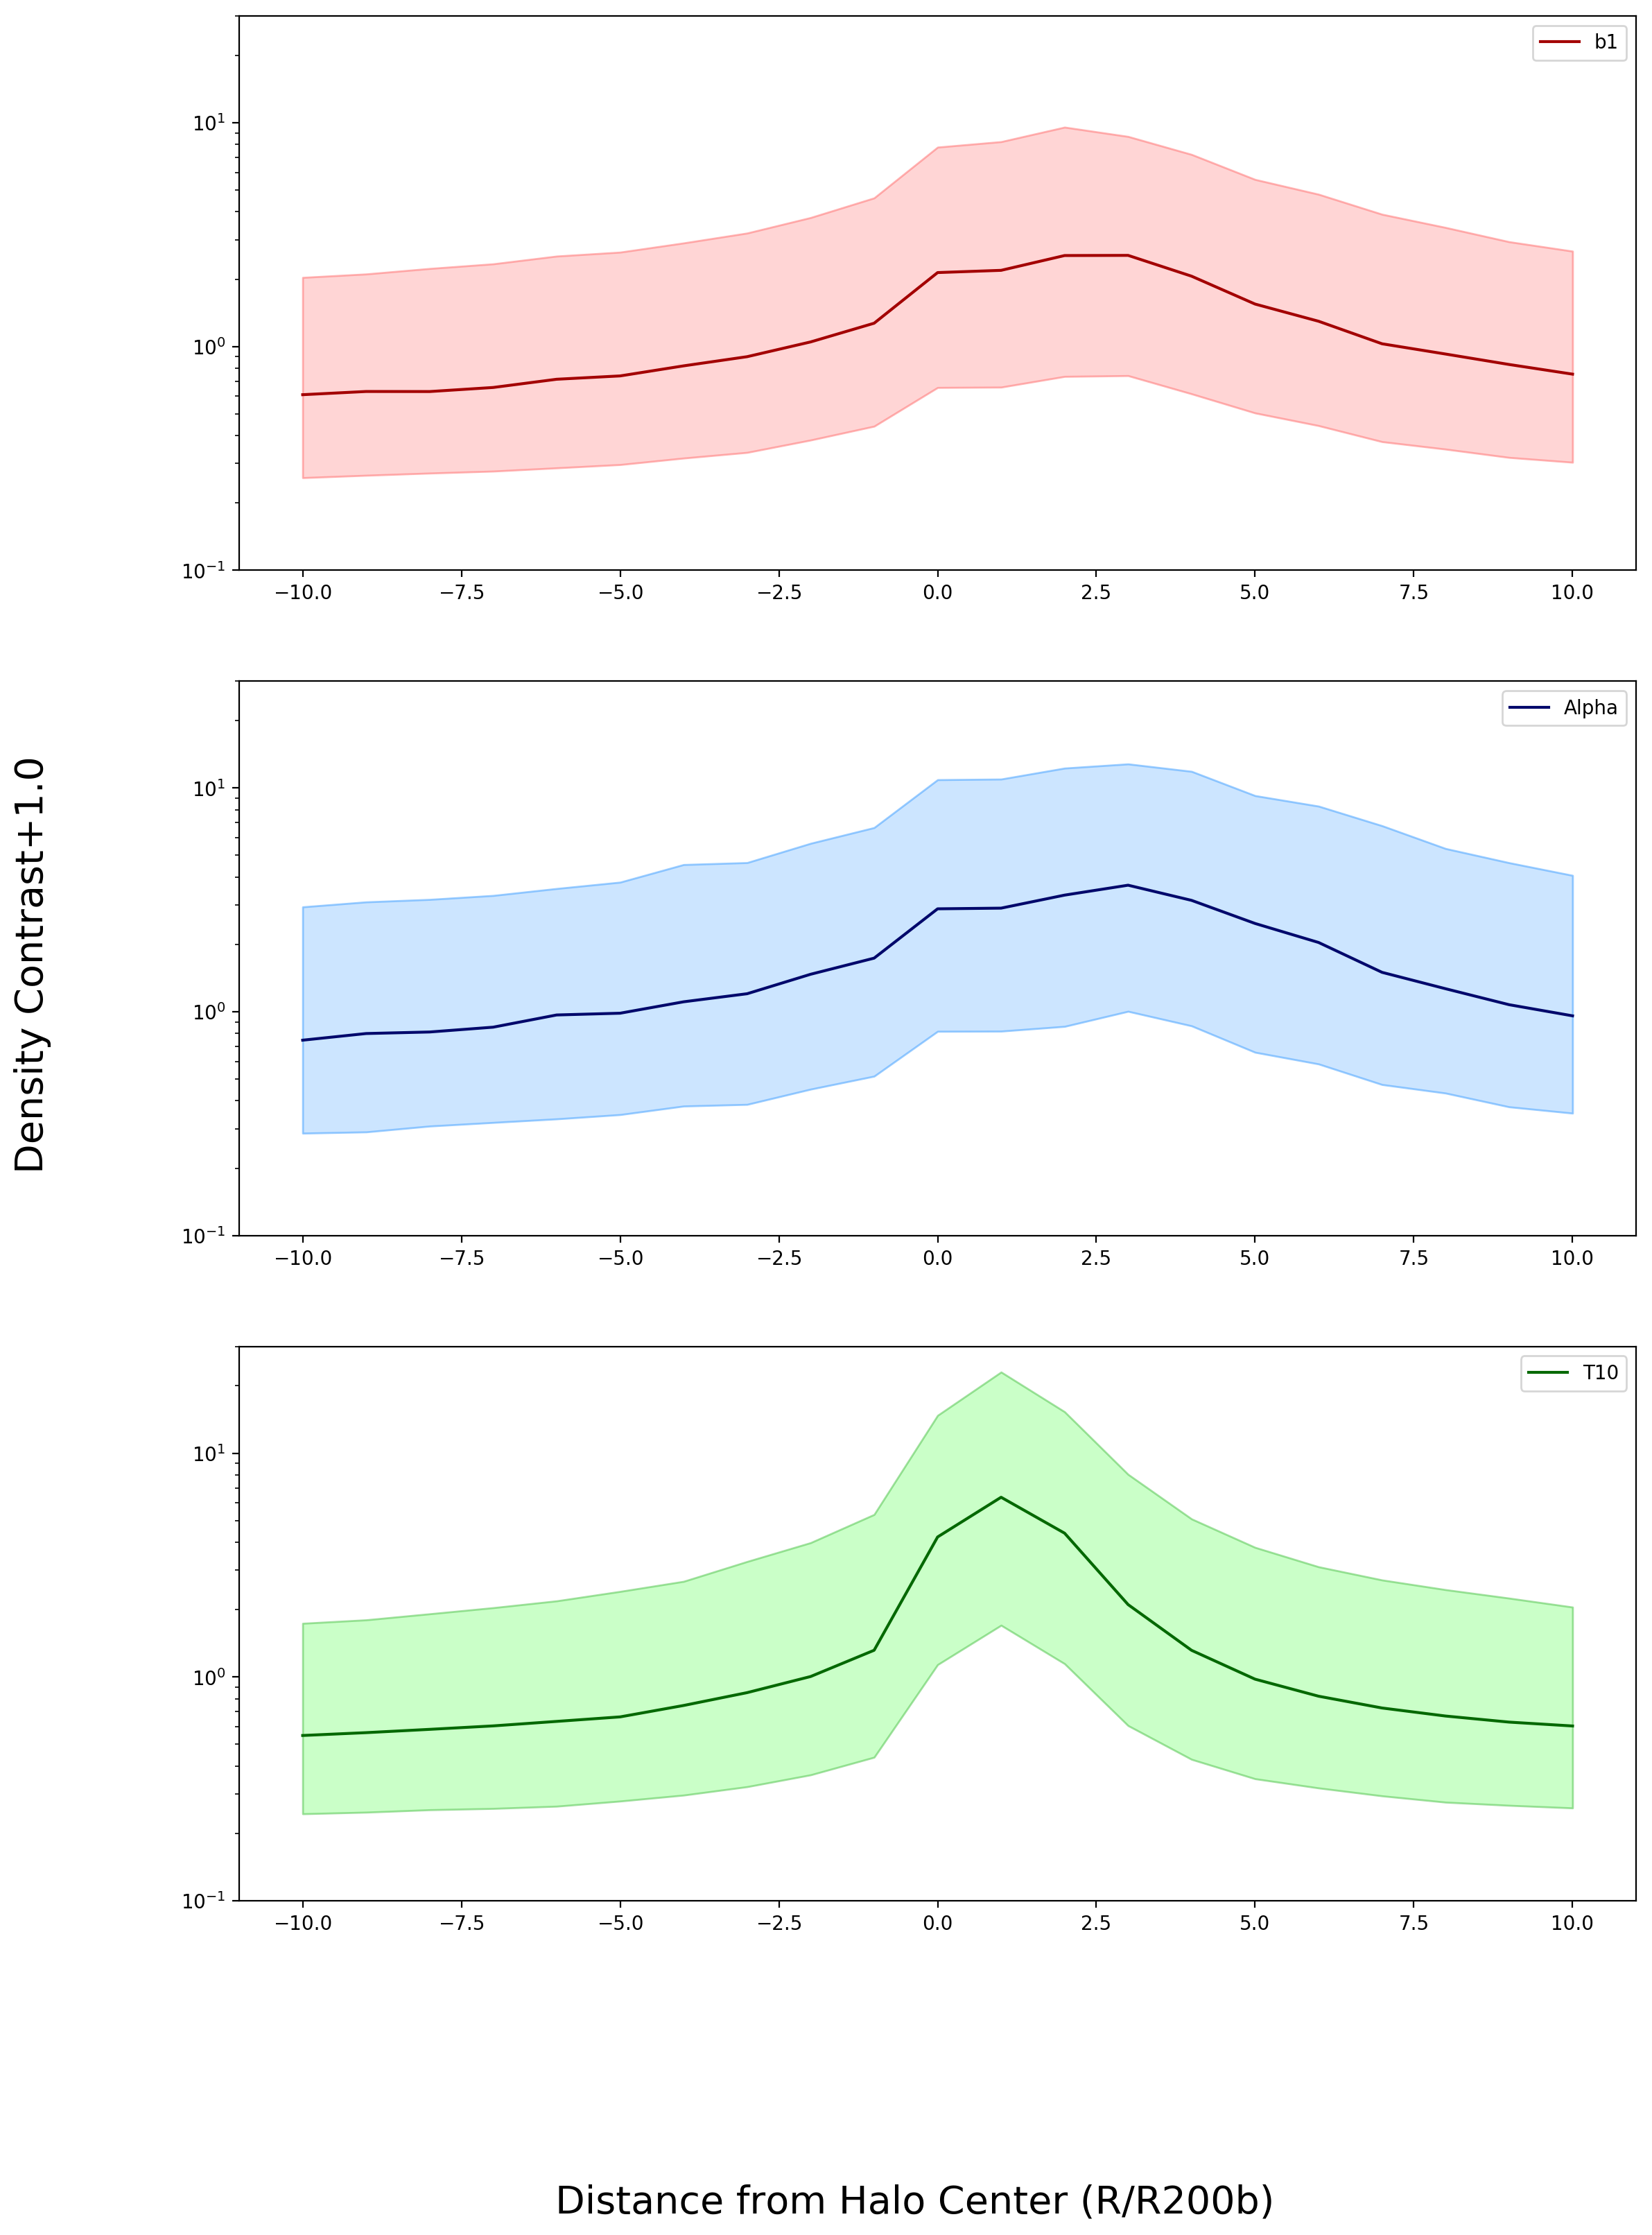

In [51]:
# This cell is specifically made to run the averagedLOSv2() function because of more complex plotting details.

fig,ax=plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(13,18),dpi=200)
fig.text(0.5, 0.0, 'Distance from Halo Center (R/R200b)', ha='center',fontsize=20)
fig.text(0.0, 0.5, 'Density Contrast', va='center', rotation='vertical',fontsize=20)

plt.subplot(3,1,1)
plt.plot(p_b1_r, df_b1_r, 'k', color='#A30000',label="b1")
plt.fill_between(p_b1_r, pt84_b1_r, pt16_b1_r,alpha=0.5, edgecolor='#FF6B6B', facecolor='#FFADAD')
plt.ylim([0.1,3e1])
plt.yscale('log')
plt.legend()

plt.subplot(3,1,2)
plt.plot(p_alpha_r, df_alpha_r, 'k', color='#00086B',label="Alpha")
plt.fill_between(p_alpha_r, pt84_alpha_r, pt16_alpha_r,alpha=0.5, edgecolor='#3a9cff', facecolor='#9bcdff')
plt.ylim([0.1,3e1])
plt.yscale('log')
plt.legend()

plt.subplot(3,1,3)
plt.plot(p_t10_r, df_t10_r, 'k', color='#036800',label="T10")
plt.fill_between(p_t10_r, pt84_t10_r, pt16_t10_r,alpha=0.5, edgecolor='#49c145', facecolor='#96ff93')
plt.ylim([0.1,3e1])
plt.yscale('log')
plt.legend()